# <u> Data Bootcamp Final Project <u>

# Data Analysis project on soccer statistics

### Topics covered:
* #### Data Analysis on Soccer players from the top 5 leagues across Europe based on different stats
* #### Correlations & Regression Analysis to study the relation between player stats 
* #### Regression Analysis to study the relationship between player stats (independent variable) & transfer fee/values (dependent variable)

Summary: 

This project will focus on teams & players from across Europe's top 5 leagues - Premier League, La Liga, Bundesliga, Ligue 1 & Serie A. The offensive, defensive & passing statistics of the players playing across these 5 leagues were downloaded from [whoscored](https://www.whoscored.com/) for the season 2018/2019. The stats were downloaded before the end of the season in April/May of 2019.  

Since whoscored had user restrictions on parsing we had to manually copy the data from the website which was annoying but didn't take too much time. After gathering all the data we worked on cleaning & combining it all into a single dataset through Python in order to look at players stats across all positions, this was to grant us ease of access going forward but also because in the modern game some players are asked by their managers to be more versatile & play in several positons along with putting in more work defensively even if they are primarily offensive players so it made sense to have all stats for certain positions. 

The second step was to combine player data with their transfer fees, we used a dataset containing transfer information since 1992 until 2018. After combining both these datasets we analysed the data. 

Our goal was to try & find top performers based on key stats like Goals, Assists, Key Passes, MotM performances, age, etc. The focus was on finding young & lesser known players preferably not playing for the elite European clubs who had been having a great 2018/2019 season. We also tried to find relationships between key stats that described players. 

Finally, we ran a regression analysis to find out what, if any, player stats had an impact on their fee/value. We looked at one position from each main position on the field, defensive (Centre-Backs), midfield (Midfielders) & offensive (Wingers). We chose not to focus on Strikers because of an already established variable that accounts for a huge amount of a strikers value which is 'Goals'.  

#### Team: *Angad Sharma*, *Soham Khanna*, *Rishabh Jamar*




**Sources:** 

https://www.whoscored.com/

https://github.com/ewenme/footy-transfer-data/tree/master/data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import re
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
df_pass = pd.read_excel('stats_passing.xlsx')
df_off = pd.read_excel('stats_offensive.xlsx')
df_def = pd.read_excel('stats_defensive.xlsx')
df_sum = pd.read_excel('stats_summary.xlsx')
# Importing stats

In [3]:
regex = re.compile(r'\s+(\d)') # matches whitespace followed by number, captures the number
df_pass['Player'] = [regex.sub(r'\1', player ) for player in df_pass['Player']]
df_off['Player'] = [regex.sub(r'\1', player ) for player in df_off['Player']]
df_def['Player'] = [regex.sub(r'\1', player ) for player in df_def['Player']]
df_sum['Player'] = [regex.sub(r'\1', player ) for player in df_sum['Player']]

In [4]:
# cols = list(df_sum.columns.values)
# print(cols)
df_sum = df_sum.sort_values('Player')
df_sum = df_sum.reset_index()
df_sum = df_sum[['League','Player','CM','KG','Apps','Mins','Yel','Red','AerialsWon','MotM']]

In [5]:
# cols = list(df_pass.columns.values)
# print(cols)
df_pass = df_pass.sort_values('Player')
df_pass = df_pass.reset_index()
df_pass = df_pass[['Team','KeyP', 'AvgP', 'PS%', 'Crosses', 'LongB', 'ThrB', 'Rating']]


In [6]:
# cols = list(df_off.columns.values)
# print(cols)
df_off = df_off.sort_values('Player')
df_off = df_off.reset_index()
df_off = df_off[['Goals', 'Assists', 'SpG', 'Drb', 'Fouled', 'Off', 'Disp', 'UnsTch']]

In [7]:
# cols = list(df_def.columns.values)
# print(cols)
df_def = df_def.rename(columns = {'Drb':'DrbPast'})
df_def = df_def.sort_values('Player')
df_def = df_def.reset_index()
df_def = df_def[['Tackles', 'Inter', 'Fouls', 'Offsides', 'DrbPast', 'Clear', 'Blocks', 'OwnG']]

In [8]:
df_all = df_sum.join(df_pass, how='outer')
df_all = df_all.join(df_off, how='outer')
df_all = df_all.join(df_def, how='outer')
# joining dataframes on index

In [9]:
# cols = list(df_all.columns.values)
# print(cols)
df_all = df_all[['League','Team', 'Player', 'CM', 'KG', 'Apps', 'Mins','Goals', 'Assists', 'Yel', 'Red','KeyP', 'AvgP', 
                 'PS%', 'Crosses', 'LongB', 'ThrB',  'SpG', 'Drb','Fouled', 'Off', 'Disp', 'UnsTch', 'Tackles',
                 'AerialsWon', 'Inter', 'Fouls', 'Offsides', 'Clear','DrbPast', 'Blocks', 'OwnG','MotM','Rating']] 

In [10]:
df_all['player_name']=df_all['Player'].str.split(",",1,True)[0]
df_all['position']=df_all['Player'].str.split(",",1,True)[1]
df_all['Age']=df_all['player_name'].str.extract('(\d\d)')
df_all['player_name']=df_all['player_name'].str[:-2]
df_all['Start_Apps']=df_all['Apps'].str.split("(",1,True)[0].astype(float)
df_all['Sub_Apps']=df_all['Apps'].str.split("(",1,True)[1].str.split(")",1,True)[0]
df_all['Sub_Apps'].fillna(value=0,inplace=True)
df_all['Player'] = df_all['player_name']
df_all = df_all.drop(columns=['player_name'])
df_all ['Age'] = df_all['Age'].astype(float)

# cleaning dataframe to extract age & positions

In [11]:
# cols = list(df_all.columns.values)
# print(cols)
df_all = df_all[['League', 'Team', 'Player','Age', 'CM', 'KG', 'Apps', 'Mins', 'Goals', 'Assists', 'Yel', 'Red', 'KeyP', 
                 'AvgP', 'PS%', 'Crosses', 'LongB', 'ThrB', 'SpG', 'Drb', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Tackles', 
                 'AerialsWon', 'Inter', 'Fouls', 'Offsides', 'Clear', 'DrbPast', 'Blocks', 'OwnG', 'MotM', 'Rating', 
                 'position', 'Start_Apps', 'Sub_Apps']]

In [12]:
df_all.replace('-',np.nan, inplace=True)

#### Appendix:  
- Mins: Minutes played	
- CM: Height (in cm)	
- KG: Weight (in kg)
- Goals: Total goals	
- Assists: Total assists
- Yel: Yellow card	
- Red: Red card	
- SpG: Shots per game	
- AerialsWon: Aerial duels won per game	
- MotM: Man of the match


- Tackles: Tackles per game	
- Inter: Interceptions per game 
- Fouls: Fouls per game	
- Offsides: Offside won per game	
- Clear: Clearances per game
- DrbPast: Dribbled past per game	
- Blocks: OutfielderBlockPerGame	
- OwnG: Own goals


- Drb: Dribbles per game
- Fouled: Fouled per game	
- Off: Offsides per game	
- Disp: Dispossessed per game
- UnsTch: Bad control per game


- KeyP: Key passes per game
- AvgP: Passes per game	
- PS% or PS: Pass success percentage	
- Crosses: Crosses per game
- LongB: Long balls per game	
- ThrB: Through balls per game 

### Importing transfer dataset

In [13]:
df0 = pd.read_csv('english-premier-league-transfers.csv')
df1 = pd.read_csv('french-ligue-1-transfers.csv')
df2 = pd.read_csv('german-bundesliga-transfers.csv')
df3 = pd.read_csv('italian-serie-a-transfers.csv')
df4 = pd.read_csv('spanish-primera-division-transfers.csv')
df = df0.append([df1,df2,df3,df4])
df = df.sort_values('year')
df = df.drop_duplicates(subset = ['name'],keep = 'last', inplace = False) # keeping latest transfer value of player 
df1 = (df.loc[df['name'].str.contains('\.')])
df1['name'] = df1['name'].str.partition('.')[0].str.slice(0, -1)
df2 = (df.loc[~ df['name'].str.contains('\.')])
df2['name'] = df2['name'].apply(lambda x:x[:int(len(x)/2)])
df = df1.append(df2)
df
# cleaning & merging transfer value data set

C:\Users\Angad\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Angad\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,club,name,age,position,club_involved,fee,transfer_movement,fee_cleaned,league,year
206,Torino Calcio,Massimiliano Manni,20.0,Left-Back,Avezzano,?,out,NaN,serie-a,1992
205,Torino Calcio,Antonino Di Maggio,18.0,Right Winger,Unknown,?,out,NaN,serie-a,1992
203,Torino Calcio,Ivanoe Lanzara,19.0,Left-Back,SC Leffe,?,out,NaN,serie-a,1992
209,Torino Calcio,Marco Bertelli,20.0,Forward,Massese,?,out,NaN,serie-a,1992
211,Torino Calcio,Massimiliano Ferina,20.0,Defender,Pavia,?,out,NaN,serie-a,1992
228,ACF Fiorentina,Ramon Aiana,19.0,Forward,Unknown,?,out,NaN,serie-a,1992
226,ACF Fiorentina,Andrea Vascotto,20.0,Midfielder,Barletta,?,in,NaN,serie-a,1992
216,Torino Calcio,Daniele Minasso,19.0,Midfielder,Retired,-,out,0.00,serie-a,1992
229,ACF Fiorentina,Celeste Pin,31.0,Defender,Verona,?,out,NaN,serie-a,1992
192,Torino Calcio,Maurizio Ferrarese,25.0,Left-Back,Vicenza,?,in,NaN,serie-a,1992


In [14]:
df = df.rename(columns={'name':'Player','position':'Position'})
df = df[['Player','Position','fee','fee_cleaned']]
#df = df.drop_duplicates(subset = ['player_name'],keep = 'last', inplace = False)
df_sum_pl = df_all[df_all['League'] == 'Premier League'].merge(df, on='Player', how='left')
df_sum_fra = df_all[df_all['League'] == 'Ligue 1'].merge(df, on='Player', how='left')
df_sum_ger = df_all[df_all['League'] == 'Bundesliga'].merge(df, on='Player', how='left')
df_sum_ita = df_all[df_all['League'] == 'Serie A'].merge(df, on='Player', how='left')
df_sum_spa = df_all[df_all['League'] == 'La Liga'].merge(df, on='Player', how='left')
df_all = df_sum_pl.append([df_sum_fra,df_sum_ger,df_sum_ita,df_sum_spa])
df_all

,League,Team,Player,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS%,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee,fee_cleaned
0,Premier League,West Ham,Aaron Cresswell,29.0,170,66,18(2),1591,NaN,1.0,1.0,NaN,0.9,40.5,81.6,0.8,1.5,NaN,0.6,0.3,0.6,0.1,0.3,0.7,1.5,1.3,1.2,0.1,0.4,2.1,0.6,0.4,NaN,NaN,6.68,"D(CL),M(L)",18.0,2,Left-Back,£4.28m,4.28
1,Premier League,Burnley,Aaron Lennon,31.0,165,63,14(2),1217,1.0,1.0,1.0,NaN,0.4,17.4,78.8,0.2,0.3,NaN,0.3,0.4,1.0,NaN,0.8,0.9,1.6,0.1,0.6,0.8,NaN,0.8,0.5,NaN,NaN,1.0,6.38,M(LR),14.0,2,Right Winger,£1.53m,1.53
2,Premier League,Huddersfield,Aaron Mooy,28.0,174,68,22(3),2049,3.0,1.0,4.0,NaN,1.6,45.0,80.2,1.6,2.0,NaN,1.6,0.6,0.5,NaN,1.6,1.2,2.3,0.6,0.5,0.9,NaN,0.7,1.2,0.2,NaN,1.0,6.77,M(C),22.0,3,Central Midfield,£8.19m,8.19
3,Premier League,Arsenal,Aaron Ramsey,28.0,178,76,13(14),1263,4.0,6.0,NaN,NaN,0.9,26.2,81.2,0.1,0.9,NaN,1.1,0.4,0.7,0.1,1.0,1.2,1.2,0.4,0.3,0.7,NaN,0.1,0.7,NaN,NaN,NaN,6.70,M(CR),13.0,14,Central Midfield,Loan,0.00
4,Premier League,Huddersfield,Aaron Rowe,18.0,0,0,1(1),69,NaN,NaN,NaN,NaN,NaN,10.0,65.0,NaN,NaN,NaN,NaN,0.5,NaN,NaN,2.0,0.5,0.5,NaN,0.5,1.0,NaN,0.5,NaN,NaN,NaN,NaN,5.92,Midfielder,1.0,1,NaN,NaN,NaN
5,Premier League,Crystal Palace,Aaron Wan-Bissaka,21.0,183,72,30,2685,NaN,2.0,4.0,1.0,0.4,34.1,73.2,0.4,1.0,NaN,0.3,1.8,0.5,NaN,0.9,1.3,3.8,1.4,2.2,0.7,0.2,3.5,0.3,0.4,NaN,2.0,7.26,D(R),NaN,0,Right-Back,-,0.00
6,Premier League,Huddersfield,Abdelhamid Sabiri,22.0,183,80,1(1),50,NaN,NaN,NaN,NaN,NaN,4.0,87.5,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,0.5,1.0,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.16,AM(L),1.0,1,Attacking Midfield,£1.35m,1.35
7,Premier League,Watford,Abdoulaye Doucouré,26.0,184,75,28(1),2522,5.0,6.0,4.0,NaN,1.0,53.7,83.4,0.1,1.8,0.1,1.5,1.0,0.4,NaN,0.9,1.7,2.1,1.1,0.9,1.0,NaN,1.8,1.1,0.2,1.0,NaN,6.82,M(C),28.0,1,Central Midfield,"End of loanJun 30, 2016",0.00
8,Premier League,Fulham,Aboubakar Kamara,24.0,177,76,5(8),690,3.0,NaN,2.0,NaN,0.8,17.3,73.3,0.1,0.5,NaN,1.6,0.9,0.3,0.5,1.0,1.8,0.6,0.9,0.1,1.8,NaN,0.4,0.3,NaN,NaN,NaN,6.35,"AM(R),FW",5.0,8,Centre-Forward,Loan,0.00
9,Premier League,Liverpool,Adam Lallana,30.0,172,73,5(8),465,NaN,NaN,1.0,NaN,0.7,23.2,82.1,0.2,0.4,NaN,0.4,0.6,0.8,NaN,0.8,0.8,1.2,0.7,0.4,0.3,NaN,0.1,0.5,0.1,NaN,NaN,6.53,AM(CLR),5.0,8,Attacking Midfield,£27.90m,27.90


In [15]:
df_all = df_all.rename(columns={'PS%':'PS'})

In [16]:
#cols = list(df_all.columns.values)
#print(cols)
df_all = df_all[['League', 'Team', 'Player','fee','Age', 'CM', 'KG', 'Apps', 'Mins', 'Goals', 'Assists', 'Yel', 'Red', 'KeyP', 
                 'AvgP', 'PS', 'Crosses', 'LongB', 'ThrB', 'SpG', 'Drb', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Tackles', 
                 'AerialsWon', 'Inter', 'Fouls', 'Offsides', 'Clear', 'DrbPast', 'Blocks', 'OwnG', 'MotM', 'Rating', 
                 'position', 'Start_Apps', 'Sub_Apps','Position', 'fee_cleaned']]
df_all

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
0,Premier League,West Ham,Aaron Cresswell,£4.28m,29.0,170,66,18(2),1591,NaN,1.0,1.0,NaN,0.9,40.5,81.6,0.8,1.5,NaN,0.6,0.3,0.6,0.1,0.3,0.7,1.5,1.3,1.2,0.1,0.4,2.1,0.6,0.4,NaN,NaN,6.68,"D(CL),M(L)",18.0,2,Left-Back,4.28
1,Premier League,Burnley,Aaron Lennon,£1.53m,31.0,165,63,14(2),1217,1.0,1.0,1.0,NaN,0.4,17.4,78.8,0.2,0.3,NaN,0.3,0.4,1.0,NaN,0.8,0.9,1.6,0.1,0.6,0.8,NaN,0.8,0.5,NaN,NaN,1.0,6.38,M(LR),14.0,2,Right Winger,1.53
2,Premier League,Huddersfield,Aaron Mooy,£8.19m,28.0,174,68,22(3),2049,3.0,1.0,4.0,NaN,1.6,45.0,80.2,1.6,2.0,NaN,1.6,0.6,0.5,NaN,1.6,1.2,2.3,0.6,0.5,0.9,NaN,0.7,1.2,0.2,NaN,1.0,6.77,M(C),22.0,3,Central Midfield,8.19
3,Premier League,Arsenal,Aaron Ramsey,Loan,28.0,178,76,13(14),1263,4.0,6.0,NaN,NaN,0.9,26.2,81.2,0.1,0.9,NaN,1.1,0.4,0.7,0.1,1.0,1.2,1.2,0.4,0.3,0.7,NaN,0.1,0.7,NaN,NaN,NaN,6.70,M(CR),13.0,14,Central Midfield,0.00
4,Premier League,Huddersfield,Aaron Rowe,NaN,18.0,0,0,1(1),69,NaN,NaN,NaN,NaN,NaN,10.0,65.0,NaN,NaN,NaN,NaN,0.5,NaN,NaN,2.0,0.5,0.5,NaN,0.5,1.0,NaN,0.5,NaN,NaN,NaN,NaN,5.92,Midfielder,1.0,1,NaN,NaN
5,Premier League,Crystal Palace,Aaron Wan-Bissaka,-,21.0,183,72,30,2685,NaN,2.0,4.0,1.0,0.4,34.1,73.2,0.4,1.0,NaN,0.3,1.8,0.5,NaN,0.9,1.3,3.8,1.4,2.2,0.7,0.2,3.5,0.3,0.4,NaN,2.0,7.26,D(R),NaN,0,Right-Back,0.00
6,Premier League,Huddersfield,Abdelhamid Sabiri,£1.35m,22.0,183,80,1(1),50,NaN,NaN,NaN,NaN,NaN,4.0,87.5,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,0.5,1.0,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.16,AM(L),1.0,1,Attacking Midfield,1.35
7,Premier League,Watford,Abdoulaye Doucouré,"End of loanJun 30, 2016",26.0,184,75,28(1),2522,5.0,6.0,4.0,NaN,1.0,53.7,83.4,0.1,1.8,0.1,1.5,1.0,0.4,NaN,0.9,1.7,2.1,1.1,0.9,1.0,NaN,1.8,1.1,0.2,1.0,NaN,6.82,M(C),28.0,1,Central Midfield,0.00
8,Premier League,Fulham,Aboubakar Kamara,Loan,24.0,177,76,5(8),690,3.0,NaN,2.0,NaN,0.8,17.3,73.3,0.1,0.5,NaN,1.6,0.9,0.3,0.5,1.0,1.8,0.6,0.9,0.1,1.8,NaN,0.4,0.3,NaN,NaN,NaN,6.35,"AM(R),FW",5.0,8,Centre-Forward,0.00
9,Premier League,Liverpool,Adam Lallana,£27.90m,30.0,172,73,5(8),465,NaN,NaN,1.0,NaN,0.7,23.2,82.1,0.2,0.4,NaN,0.4,0.6,0.8,NaN,0.8,0.8,1.2,0.7,0.4,0.3,NaN,0.1,0.5,0.1,NaN,NaN,6.53,AM(CLR),5.0,8,Attacking Midfield,27.90


# <u><font color= 'red'> *Finding relationships between key stats* </font> <u>

0.7327237748177882

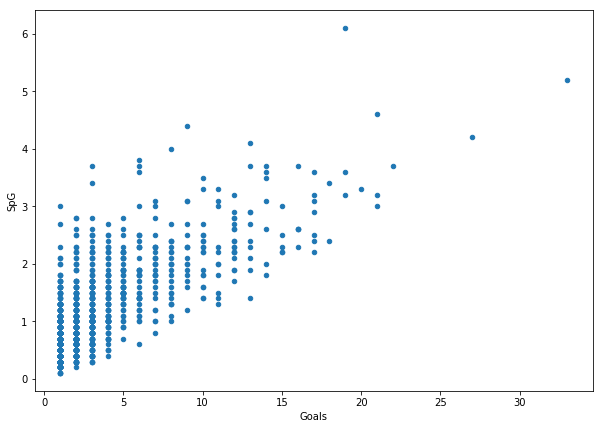

In [17]:
df_all.plot.scatter(x = 'Goals', y = 'SpG', figsize=(10,7))
df_all['Goals'].corr(df_all['SpG'])

In [18]:
reg_mul = smf.ols('Goals ~ SpG', data= df_all[df_all['position'].str.contains('FW')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:                  Goals   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     469.1
Date:                Thu, 16 May 2019   Prob (F-statistic):           1.71e-70
Time:                        18:02:26   Log-Likelihood:                -1121.5
No. Observations:                 424   AIC:                             2247.
Df Residuals:                     422   BIC:                             2255.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5673      0.379     -4.132      0.0

### Notes:

#### High correlation between Goals & Shots per game

0.14833017070852453

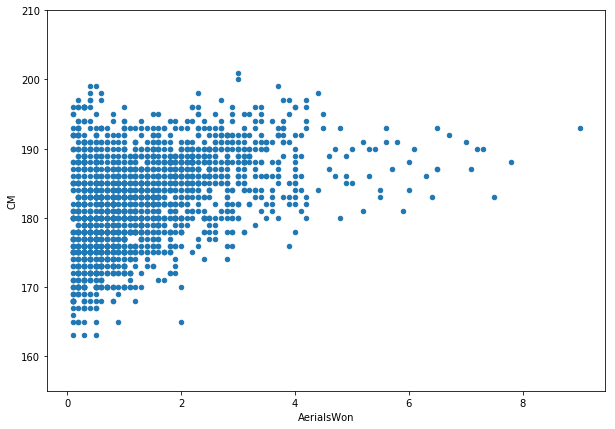

In [19]:
df_all.plot.scatter(x = 'AerialsWon', y = 'CM', figsize=(10,7), ylim = (155,210))
df_all['AerialsWon'].corr(df_all['CM'])

In [20]:
reg_mul = smf.ols('AerialsWon ~ CM ', data= df_all).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:             AerialsWon   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     52.87
Date:                Thu, 16 May 2019   Prob (F-statistic):           4.84e-13
Time:                        18:02:27   Log-Likelihood:                -3554.8
No. Observations:                2352   AIC:                             7114.
Df Residuals:                    2350   BIC:                             7125.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1769      0.204     -0.866      0.3

### Notes:

#### Low correlation between Height & Aerial Duels won per game, data points to other factors as being determinant of Aerials Won which is a surprise, player aggression & tenacity could be a possible determinant for Aerials won but that atribute can't be quantified.

0.6251878851648779

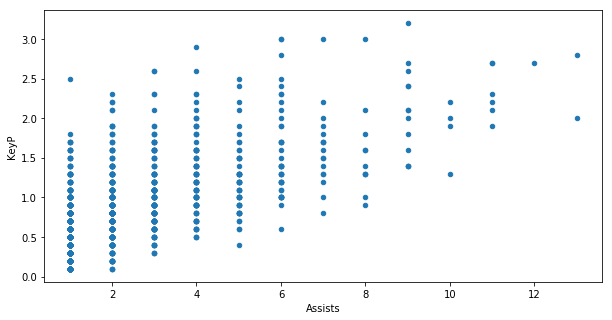

In [21]:
df_all.plot.scatter(x = 'Assists', y = 'KeyP', figsize = (10,5))
df_all['Assists'].corr(df_all['KeyP'])

In [22]:
reg_mul = smf.ols('Assists ~ KeyP', data= df_all).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:                Assists   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     746.2
Date:                Thu, 16 May 2019   Prob (F-statistic):          2.43e-127
Time:                        18:02:27   Log-Likelihood:                -2148.7
No. Observations:                1165   AIC:                             4301.
Df Residuals:                    1163   BIC:                             4312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4633      0.086      5.368      0.0

In [23]:
reg_mul = smf.ols('Assists ~ KeyP + Mins + ThrB + LongB', data= df_all).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:                Assists   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     100.9
Date:                Thu, 16 May 2019   Prob (F-statistic):           8.99e-60
Time:                        18:02:27   Log-Likelihood:                -822.88
No. Observations:                 416   AIC:                             1656.
Df Residuals:                     411   BIC:                             1676.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1528      0.281     -4.108      0.0

### Notes:
#### High correlation between Key Passes & Assists, a lot of passing statistics account for the variance in Assists which was makes sense but the interesting thing is that 'Long Balls' has an inverse relationship with Assists according to the analysis. If a player has a high long balls per game stat his assists tally is likely to be lower according to the findings.

0.6441359947811067

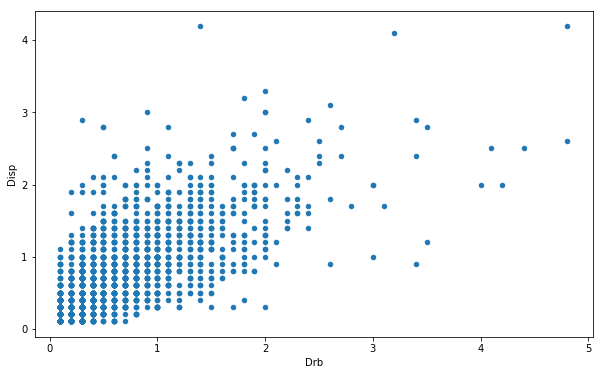

In [24]:
df_all.plot.scatter(x = 'Drb', y = 'Disp', figsize = (10,6))
df_all['Drb'].corr(df_all['Disp'])

0.5468866678084544

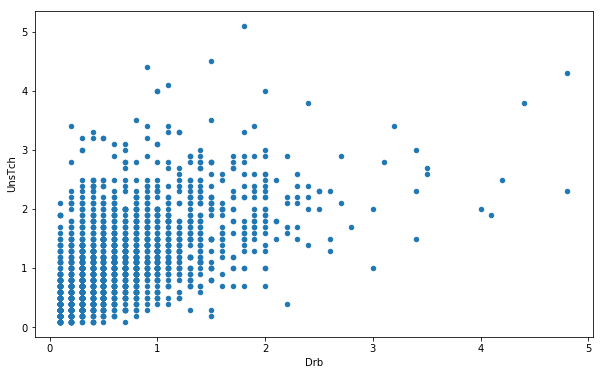

In [25]:
df_all.plot.scatter(x = 'Drb', y = 'UnsTch', figsize = (10,6))
df_all['Drb'].corr(df_all['UnsTch'])

0.4271620793495614

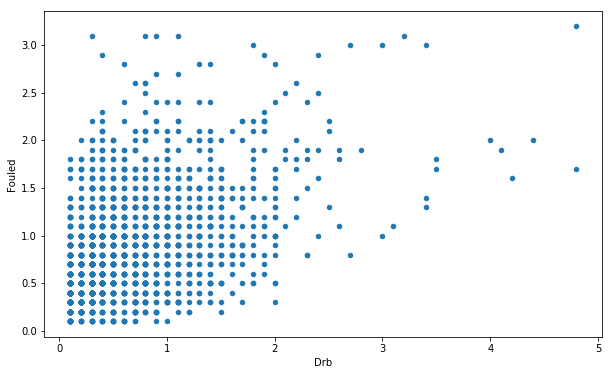

In [26]:
df_all.plot.scatter(x = 'Drb', y = 'Fouled', figsize = (10,6))
df_all['Drb'].corr(df_all['Fouled'])

In [27]:
reg_mul = smf.ols('Drb ~ UnsTch + Fouled + Disp', data= df_all).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:                    Drb   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     484.3
Date:                Thu, 16 May 2019   Prob (F-statistic):          3.23e-232
Time:                        18:02:28   Log-Likelihood:                -1032.0
No. Observations:                1854   AIC:                             2072.
Df Residuals:                    1850   BIC:                             2094.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0658      0.022      3.028      0.0

### Notes:

#### Moderate correlation between Dribbles per game & Bad touches per game per game, data points to other factors as being determinant of Aerials Won which is a surprise

-0.04862948158470857

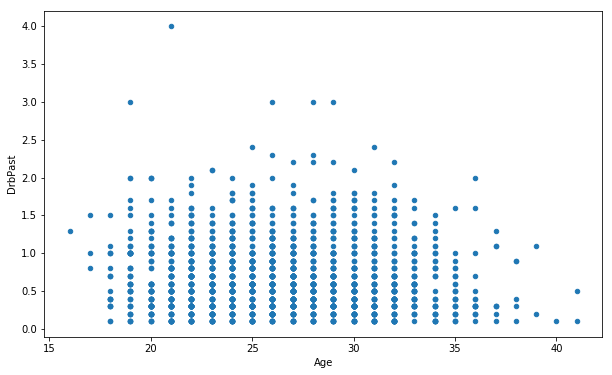

In [28]:
df_all.plot.scatter(x = 'Age', y = 'DrbPast', figsize = (10,6))
df_all['Age'].corr(df_all['DrbPast'])

### Notes:

#### Negative correlation between Age & Dribbled past per game, which could be because of the fact that as players age they get more experienced and therefore become more disciplined defensively.

0.7517667854878013

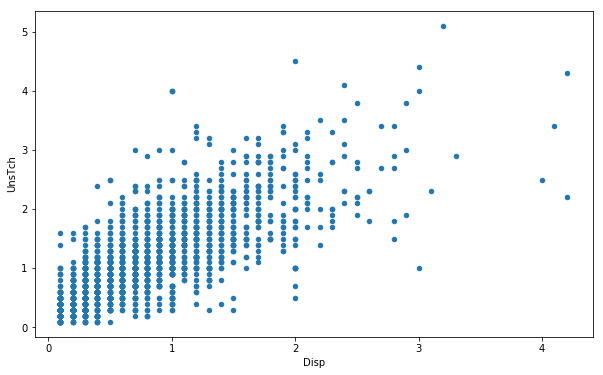

In [29]:
df_all.plot.scatter(x = 'Disp', y = 'UnsTch', figsize = (10,6))
df_all['Disp'].corr(df_all['UnsTch'])

0.15242693754451989

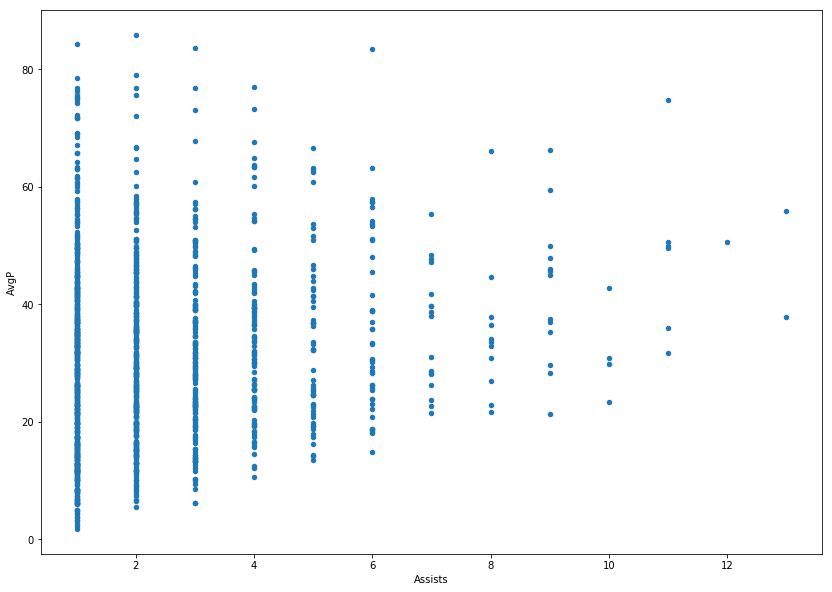

In [30]:
df_all.plot.scatter(x = 'Assists', y = 'AvgP', figsize = (14,10))
df_all['Assists'].corr(df_all['AvgP'])

0.1367342522789771

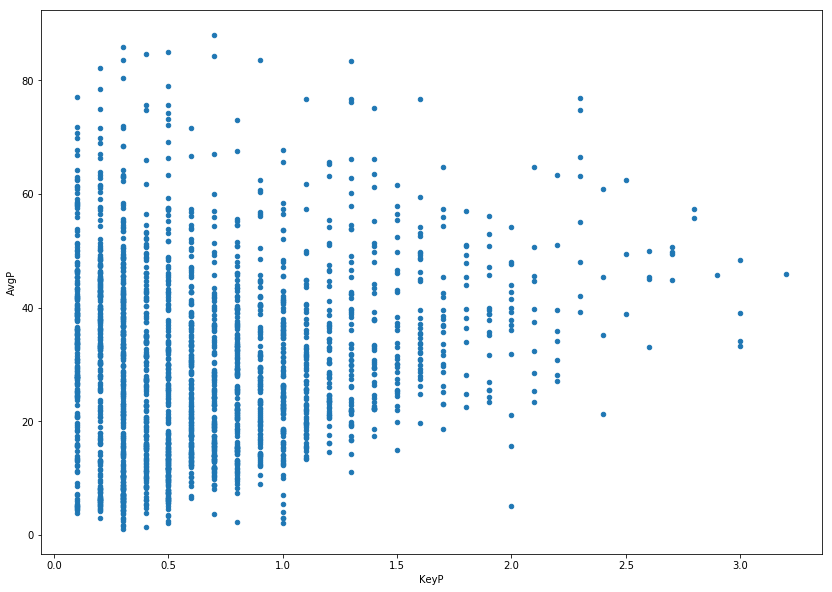

In [31]:
df_all.plot.scatter(x = 'KeyP', y = 'AvgP', figsize = (14,10))
df_all['KeyP'].corr(df_all['AvgP'])

0.023735799357330584

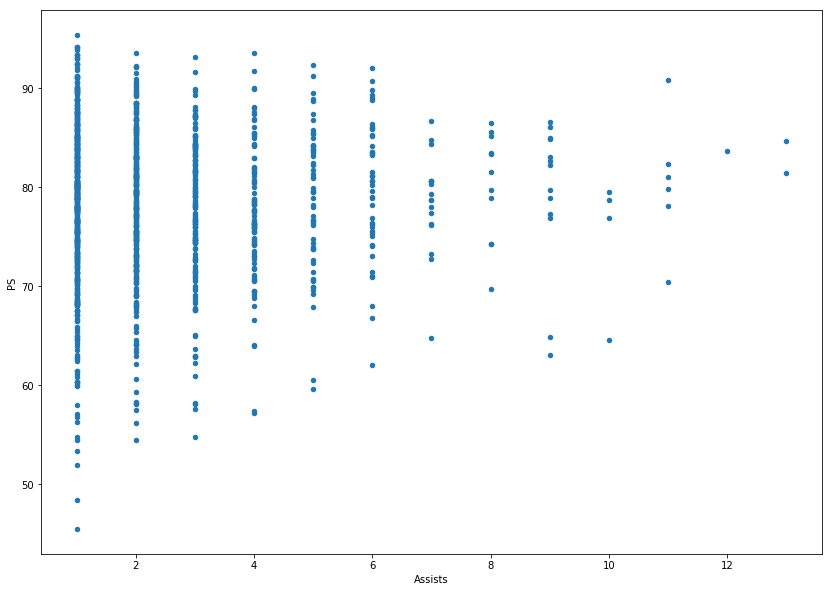

In [32]:
df_all.plot.scatter(x = 'Assists', y = 'PS', figsize = (14,10))
df_all['Assists'].corr(df_all['PS'])

0.018601117252318215

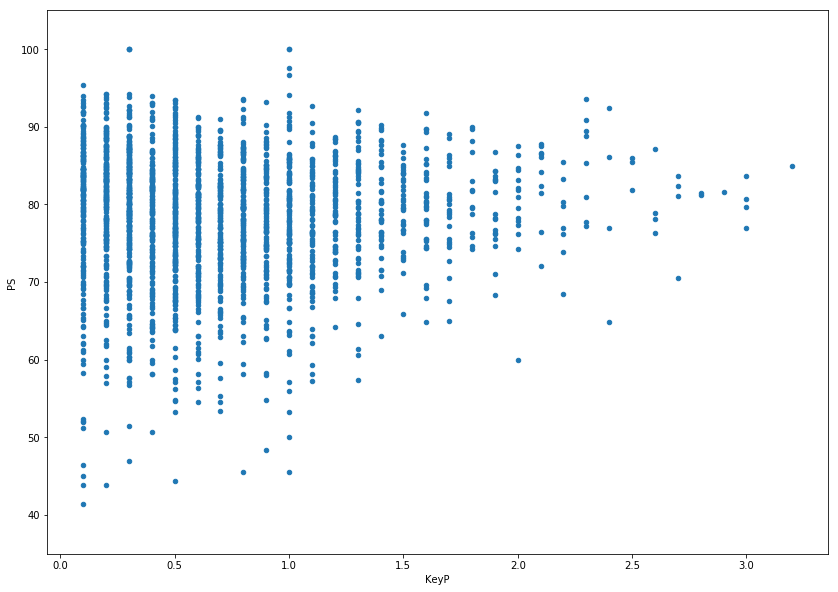

In [33]:
df_all.plot.scatter(x = 'KeyP', y = 'PS', figsize = (14,10), ylim=(35,105))
df_all['KeyP'].corr(df_all['PS'])

### Notes:

#### There's almost no correlation or extremely low correlation between the number of passes a player plays per game & the assists & Key Passes that result from them. 

#### There's also almost no correlation between a players pass success rate & the key passes & assists they make which is a crucial finding because  a players pass success rate is helpful in reducing the possession loss during the game or in controlling the tempo of the game but it has very little or no impact whatsoever on assists or key passes that lead to goal scoring opportunities or goals.

# <u><font color= 'red'> *Data Analysis to find special performers* </font> <u>

In [34]:
df_all.loc[(df_all['Mins'] < 1000) & (df_all['Assists'] >= 3)].sort_values('Assists',ascending= False)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
67,Premier League,Manchester City,Benjamin Mendy,£51.75m,24.0,185,85,9,810,NaN,5.0,1.0,NaN,1.3,62.8,87.4,1.2,1.8,NaN,0.7,0.8,0.2,NaN,1.0,1.0,1.4,0.9,1.0,1.1,0.4,1.6,0.9,0.4,NaN,NaN,7.31,"D(L),DMC,M(L)",NaN,0,Left-Back,51.75
454,Serie A,Sampdoria,Riccardo Saponara,Loan fee:£1.80m,27.0,184,73,11(11),908,2.0,4.0,3.0,NaN,1.1,20.3,69.4,0.1,0.7,0.1,1.1,0.7,0.7,0.3,1.8,1.5,0.5,0.3,0.2,0.7,NaN,0.4,0.4,NaN,NaN,NaN,6.44,AM(C),11.0,11,Attacking Midfield,1.80
301,Premier League,Fulham,Luciano Vietto,Loan,25.0,174,69,10(10),987,1.0,4.0,1.0,NaN,1.1,19.3,78.8,0.4,0.2,0.1,1.2,0.8,1.0,NaN,1.3,1.3,0.8,0.3,0.3,0.7,NaN,0.3,0.8,NaN,NaN,NaN,6.48,"AM(R),FW",10.0,10,Centre-Forward,0.00
370,Premier League,Chelsea,Olivier Giroud,£15.30m,32.0,192,93,7(17),804,2.0,4.0,1.0,NaN,0.7,10.5,68.0,NaN,0.2,NaN,1.2,0.1,0.3,0.3,0.3,0.8,0.1,1.5,0.1,0.5,NaN,0.3,0.1,NaN,NaN,NaN,6.49,FW,7.0,17,Centre-Forward,15.30
25,Premier League,Manchester United,Alexis Sánchez,£30.60m,30.0,169,62,8(9),791,1.0,3.0,3.0,NaN,1.2,20.5,74.5,0.3,1.4,0.1,1.0,0.8,1.0,0.5,1.4,1.0,0.9,0.4,0.5,0.8,NaN,0.1,0.4,NaN,NaN,NaN,6.67,"M(CLR),FW",8.0,9,Left Winger,30.60
152,Bundesliga,Hannover 96,Ihlas Bebou,£4.05m,24.0,183,77,10,899,3.0,3.0,1.0,NaN,1.4,30.8,70.8,0.9,0.6,0.2,2.1,2.4,1.6,0.3,1.6,2.4,1.4,1.6,0.9,0.8,NaN,0.7,0.5,0.2,NaN,4.0,7.24,"AM(CLR),FW",NaN,0,Right Winger,4.05
292,La Liga,Villarreal,Manuel Morlanes,NaN,20.0,178,75,7(2),603,NaN,3.0,2.0,NaN,1.0,34.6,84.2,NaN,2.4,0.2,0.3,0.8,0.7,NaN,0.7,0.2,2.2,1.1,0.6,1.4,NaN,1.0,1.3,0.3,NaN,1.0,6.87,M(C),7.0,2,NaN,NaN
278,La Liga,Real Sociedad,Luca Sangalli,-,24.0,167,74,9(6),798,1.0,3.0,NaN,NaN,0.5,16.8,72.6,0.3,0.2,0.1,0.5,0.7,0.9,NaN,1.0,1.1,1.0,0.5,0.3,0.5,NaN,0.1,1.0,0.1,NaN,1.0,6.47,AM(C),9.0,6,Attacking Midfield,0.00
26,La Liga,Celta Vigo,Andrew Hjulsager,"End of loanJun 30, 2018",24.0,175,73,1(12),262,NaN,3.0,1.0,NaN,0.5,6.2,76.3,0.3,0.2,NaN,0.2,0.5,0.2,0.1,0.5,0.8,1.1,0.1,0.1,0.5,NaN,0.1,1.2,NaN,NaN,NaN,6.25,Midfielder,1.0,12,Right Winger,0.00
500,Serie A,Napoli,Simone Verdi,£22.05m,26.0,171,62,7(11),535,3.0,3.0,NaN,NaN,0.7,13.9,87.2,0.5,0.5,0.1,0.8,0.6,0.3,NaN,0.7,1.2,0.7,0.1,0.2,0.6,NaN,0.1,0.2,NaN,NaN,1.0,6.53,"AM(CLR),FW",7.0,11,Right Winger,22.05


### Notes:
- ##### Benjamin Mendy - stand out performer, living up to his price tag but season ravaged by injury
- ##### Olivier Giroud - Impact player, great to come off the bench, Key passes & High Aerials Won make him a potent substitute

In [35]:
df_all.sort_values('KeyP',ascending= False).head(30)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
10,Serie A,Atalanta,Alejandro Gómez,NaN,31.0,165,68,30(1),2569,6.0,9.0,4.0,NaN,3.2,45.9,85.0,2.8,2.2,0.2,3.0,2.2,2.6,0.2,2.2,1.7,0.5,0.2,0.3,0.8,NaN,0.1,0.6,NaN,NaN,6.0,7.61,"M(CL),FW",30.0,1,NaN,NaN
336,Ligue 1,Lyon,Memphis Depay,£14.40m,25.0,176,78,24(7),2300,7.0,8.0,5.0,NaN,3.0,34.1,79.7,2.1,1.5,0.3,3.1,1.7,0.8,0.2,1.8,2.2,0.3,0.3,0.3,1.0,NaN,NaN,0.4,0.1,NaN,3.0,7.26,"AM(CL),FW",24.0,7,Centre-Forward,14.400
116,Ligue 1,Marseille,Dimitri Payet,£26.37m,32.0,175,77,19(6),1601,4.0,6.0,2.0,NaN,3.0,33.2,76.9,2.3,1.5,0.2,1.3,0.6,1.2,NaN,1.1,1.4,0.4,0.3,0.3,0.3,NaN,0.2,0.6,NaN,NaN,NaN,6.94,M(CLR),19.0,6,Attacking Midfield,26.370
213,Bundesliga,Hoffenheim,Kerem Demirbay,£1.53m,25.0,182,72,21(2),1769,4.0,7.0,5.0,NaN,3.0,48.3,80.7,1.6,2.8,0.2,2.3,2.0,1.2,NaN,2.0,1.8,2.2,0.8,0.9,1.6,NaN,0.8,1.5,0.4,NaN,6.0,7.59,AM(C),21.0,2,Central Midfield,1.530
210,Premier League,Leicester,James Maddison,£22.50m,22.0,175,73,30(1),2416,7.0,6.0,3.0,1.0,3.0,39.0,83.6,1.9,2.1,0.3,2.3,1.4,2.1,0.1,1.0,1.2,1.3,0.3,0.4,0.6,NaN,0.2,1.0,0.1,NaN,3.0,7.25,AM(CLR),30.0,1,Attacking Midfield,22.500
322,Serie A,Lazio,Luis Alberto,£3.60m,26.0,182,70,23(2),1829,3.0,4.0,5.0,1.0,2.9,45.8,81.6,1.7,2.6,0.1,2.5,0.8,1.0,0.1,1.6,1.7,1.9,0.6,0.4,0.9,NaN,0.3,1.2,0.1,NaN,2.0,7.02,"AM(CL),FW",23.0,2,Attacking Midfield,3.600
364,Ligue 1,Paris Saint-Germain,Neymar,£199.80m,27.0,175,68,13,1129,13.0,6.0,2.0,NaN,2.8,57.3,81.2,1.0,2.6,1.2,3.7,4.8,3.2,0.5,4.2,4.3,0.8,0.3,0.4,0.9,NaN,0.1,1.1,NaN,NaN,6.0,8.53,"AM(CLR),FW",NaN,0,Left Winger,199.800
274,La Liga,Barcelona,Lionel Messi,-,31.0,170,72,27(3),2456,33.0,13.0,3.0,NaN,2.8,55.8,81.5,0.4,3.6,1.0,5.2,4.1,1.9,0.5,2.5,1.9,0.4,0.2,0.1,0.7,NaN,NaN,0.5,NaN,NaN,15.0,8.58,"AM(CR),FW",27.0,3,Right Winger,0.000
488,Ligue 1,Nimes,Téji Savanier,NaN,27.0,171,62,27,2416,5.0,11.0,6.0,1.0,2.7,49.8,70.5,2.7,6.3,0.1,2.1,2.4,2.9,NaN,1.4,2.0,3.1,1.7,1.8,1.6,NaN,1.7,2.2,0.5,NaN,5.0,7.90,DMC,NaN,0,NaN,NaN
199,Bundesliga,Bayer Leverkusen,Julian Brandt,£315k,22.0,186,84,26(3),2314,4.0,11.0,NaN,NaN,2.7,49.5,81.1,1.1,2.4,0.2,1.8,1.5,0.7,0.1,1.7,2.1,0.9,1.0,0.5,0.4,NaN,0.2,1.0,NaN,NaN,3.0,7.14,"AM(CLR),FW",26.0,3,Left Winger,0.315


### Notes:

- ##### Memphis Depay - His value has probably increased because of the season he's had, could be a good acquisition for teams, good potential for parent club to make a big profit off of him.

- ##### Kerem Demirbay - Great prospect, relatively low price. 6 MotM & a healthy tally of goals & assists make him a great player for teams to take a chance on

In [36]:
(df_all.loc[(df_all['Age'] < 25)].sort_values('Assists',ascending= False)).head(15)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
160,Bundesliga,Borussia Dortmund,Jadon Sancho,£7.05m,19.0,180,76,23(7),2168,11.0,13.0,2.0,NaN,2.0,37.8,84.7,0.8,0.6,0.1,1.3,3.1,1.1,0.1,1.7,2.8,0.6,NaN,0.4,0.1,NaN,0.2,0.6,NaN,NaN,6.0,7.53,AM(LR),23.0,7,Right Winger,7.050
369,Ligue 1,Lille,Nicolas Pepe,NaN,23.0,183,73,32,2865,19.0,11.0,1.0,NaN,1.9,31.6,78.1,0.3,0.7,0.3,3.2,2.7,3.0,0.3,2.8,2.9,0.7,1.2,0.4,0.6,NaN,0.1,0.6,NaN,NaN,12.0,7.64,"AM(R),FW",NaN,0,NaN,NaN
191,Bundesliga,Bayern Munich,Joshua Kimmich,£1.35m,24.0,176,73,30,2700,2.0,11.0,4.0,NaN,2.3,74.7,90.8,2.3,4.3,0.1,0.7,1.1,1.5,NaN,0.6,1.0,1.2,0.7,1.0,0.9,0.1,0.9,0.9,0.3,NaN,3.0,7.48,"D(CR),DMC",NaN,0,Right-Back,1.350
199,Bundesliga,Bayer Leverkusen,Julian Brandt,£315k,22.0,186,84,26(3),2314,4.0,11.0,NaN,NaN,2.7,49.5,81.1,1.1,2.4,0.2,1.8,1.5,0.7,0.1,1.7,2.1,0.9,1.0,0.5,0.4,NaN,0.2,1.0,NaN,NaN,3.0,7.14,"AM(CLR),FW",26.0,3,Left Winger,0.315
293,Premier League,Manchester City,Leroy Sané,£45.45m,23.0,183,75,19(7),1619,9.0,9.0,1.0,NaN,1.4,29.6,84.9,0.6,0.1,0.1,1.9,2.0,0.5,0.6,1.3,2.3,0.7,0.4,0.2,0.3,NaN,0.1,0.6,0.1,NaN,1.0,7.36,M(CLR),19.0,7,Left Winger,45.450
416,Bundesliga,Eintracht Frankfurt,Sébastien Haller,£6.30m,24.0,190,82,23(4),2107,14.0,9.0,3.0,NaN,1.4,28.3,63.1,NaN,0.4,0.1,2.0,1.0,1.5,0.7,1.7,3.1,0.9,7.2,0.6,1.5,NaN,0.8,0.5,NaN,NaN,3.0,7.63,FW,23.0,4,Centre-Forward,6.300
394,Premier League,Manchester City,Raheem Sterling,£57.33m,24.0,170,69,25(3),2237,15.0,9.0,2.0,NaN,2.1,37.5,86.1,0.4,0.3,NaN,2.2,2.5,1.3,0.4,2.6,2.3,0.9,0.3,0.5,1.0,NaN,0.1,0.4,NaN,NaN,8.0,7.71,"M(CLR),FW",25.0,3,Right Winger,57.330
122,Bundesliga,Borussia M.Gladbach,Florian Neuhaus,"End of loanJun 30, 2018",22.0,183,74,22(7),1846,3.0,8.0,3.0,NaN,0.9,26.9,83.5,0.1,1.6,0.1,1.5,0.9,1.1,NaN,1.1,1.1,0.7,0.2,0.3,0.8,NaN,0.7,0.7,NaN,NaN,NaN,6.67,M(C),22.0,7,Central Midfield,0.000
70,Premier League,Manchester City,Bernardo Silva,£45.00m,24.0,173,64,26(4),2378,6.0,7.0,3.0,NaN,1.9,47.1,86.7,0.3,2.2,0.2,1.5,1.2,0.7,0.1,1.0,1.3,1.3,0.2,0.6,0.9,NaN,0.7,1.4,0.1,NaN,2.0,7.20,AM(CLR),26.0,4,Right Winger,45.000
59,La Liga,Celta Vigo,Brais Méndez,-,22.0,187,76,25(2),2156,6.0,7.0,5.0,NaN,1.7,37.9,78.7,0.9,1.4,NaN,2.5,0.7,2.1,0.4,1.4,1.6,2.1,1.1,0.9,1.2,NaN,0.6,1.3,0.1,NaN,1.0,7.11,AM(CR),25.0,2,Attacking Midfield,0.000


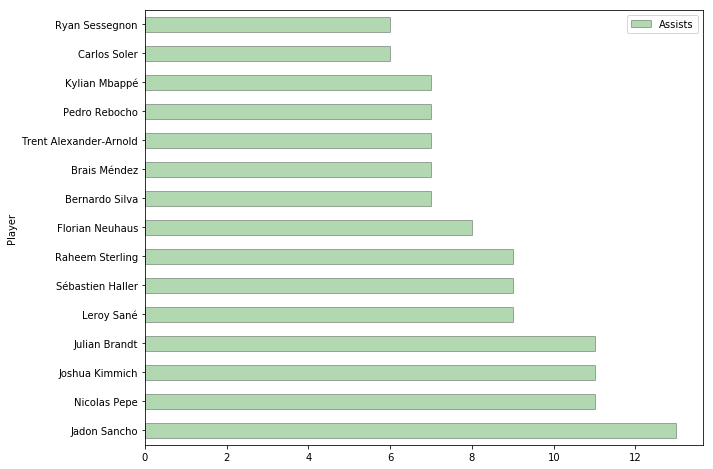

In [37]:
(df_all.loc[(df_all['Age'] < 25)].sort_values('Assists',ascending= False)).head(15).plot.barh(x='Player',y='Assists',figsize=(10,8), color='g',alpha =0.3, edgecolor='k')

### Notes:

- ##### Jadon Sancho - 19 years old, only cost 7 million for Dortmund to acquire him. He tops the assists chart for players under 25 years of age, his tranasfer value will have appreciated incredibly after this season

- #####  Trent Alexander Arnold - Another bright prospect with a high assist tally, academy player, his age, impressive attacking & defensive stats will have increased his value tremendously. 

- ##### Nicolas Pepe & Julian Brandt - Both have had impressive seasons, their acquirement cost their parents clubs next to nothing. Brandt particularly has a high key pass stat.

In [38]:
(df_all.loc[(df_all['Mins'] > 700) & (df_all['Age'] < 25)]).sort_values('AerialsWon',ascending= False).head(20)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
78,Premier League,Cardiff,Callum Paterson,NaN,24.0,183,76,21(6),1996,4.0,1.0,4.0,NaN,0.9,20.4,48.4,0.2,0.5,NaN,1.5,0.2,1.1,0.4,0.4,1.1,0.8,7.5,0.3,1.5,NaN,1.0,0.8,0.1,NaN,1.0,6.82,"D(R),M(CR),FW",21.0,6,NaN,NaN
450,Premier League,Huddersfield,Steve Mounie,NaN,24.0,190,83,17(10),1623,2.0,3.0,1.0,1.0,0.7,18.8,63.7,NaN,0.1,NaN,2.1,0.4,0.6,0.4,1.3,2.1,0.3,7.3,0.1,1.0,NaN,0.5,0.3,NaN,NaN,2.0,6.79,FW,17.0,10,NaN,NaN
416,Bundesliga,Eintracht Frankfurt,Sébastien Haller,£6.30m,24.0,190,82,23(4),2107,14.0,9.0,3.0,NaN,1.4,28.3,63.1,NaN,0.4,0.1,2.0,1.0,1.5,0.7,1.7,3.1,0.9,7.2,0.6,1.5,NaN,0.8,0.5,NaN,NaN,3.0,7.63,FW,23.0,4,Centre-Forward,6.300
19,Premier League,Fulham,Aleksandar Mitrovic,£18.18m,24.0,187,90,32,2832,10.0,2.0,6.0,NaN,0.9,27.7,71.5,NaN,0.4,0.1,3.5,0.6,1.6,1.1,2.4,2.9,0.6,6.5,0.2,1.6,NaN,1.6,0.3,0.3,NaN,4.0,7.03,FW,NaN,0,Centre-Forward,18.180
322,Ligue 1,Nantes,Matt Miazga,"End of loanJan 24, 2019",23.0,191,84,8,720,NaN,NaN,5.0,NaN,0.3,53.4,81.0,0.1,2.9,0.1,0.5,NaN,0.5,NaN,0.1,0.3,1.5,5.8,1.5,1.4,1.1,4.9,0.3,0.9,NaN,NaN,6.71,D(C),NaN,0,Centre-Back,0.000
260,Bundesliga,VfB Stuttgart,Marc-Oliver Kempf,NaN,24.0,186,87,20,1756,2.0,NaN,3.0,NaN,0.4,45.4,81.7,0.2,3.2,NaN,0.6,0.1,1.4,NaN,0.2,0.6,1.5,4.9,1.9,1.1,0.5,5.7,0.6,1.0,NaN,3.0,6.98,D(C),NaN,0,NaN,NaN
81,Serie A,Genoa,Christian Kouamé,£4.50m,21.0,185,70,29(4),2684,4.0,5.0,4.0,NaN,1.2,24.6,67.9,0.2,0.5,NaN,2.2,1.1,2.2,0.4,2.1,2.8,0.8,4.9,0.7,1.0,NaN,0.6,0.3,0.1,NaN,1.0,7.04,"AM(L),FW",29.0,4,Centre-Forward,4.500
457,Bundesliga,RasenBallsport Leipzig,Yussuf Poulsen,NaN,24.0,193,84,24(3),2164,15.0,2.0,2.0,NaN,1.1,25.7,62.2,0.2,0.2,0.1,2.2,0.7,1.6,0.6,2.0,3.1,0.7,4.8,0.3,1.9,0.1,1.0,0.6,0.1,NaN,4.0,7.37,"AM(R),FW",24.0,3,NaN,NaN
509,La Liga,Leganes,Youssef En-Nesyri,£5.40m,21.0,189,73,18(8),1745,8.0,2.0,6.0,NaN,0.5,15.1,56.2,0.1,0.5,NaN,2.4,0.8,1.2,0.6,1.8,1.8,0.5,4.6,0.2,1.2,NaN,0.8,0.6,0.1,NaN,4.0,6.93,FW,18.0,8,Centre-Forward,5.400
146,Bundesliga,Hannover 96,Hendrik Weydandt,-,23.0,195,94,14(10),1404,5.0,1.0,1.0,NaN,0.9,14.4,58.0,0.2,0.1,NaN,2.2,0.3,0.9,0.3,1.2,3.2,0.6,4.5,0.2,1.3,NaN,1.5,0.7,0.2,NaN,NaN,6.67,FW,14.0,10,Centre-Forward,0.000


### Notes:

- ##### Sebastien Haller - He is  He has sored 14 goals this season & has an incredibly high Aerials Won stat at 7.2 per game, any team whose style of play involves long balls would be interested in this players acquisition. 

- ##### Yussuf Poulsen - He stands at 193cm & has scored 15 goals this season. With a slightly lower aerials won stat at 4.8 per game, he is still a good prospect for clubs looking for a target man. 

In [39]:
df_all.loc[(df_all['Age'] < 24) & (df_all['Goals'] >= 3)].sort_values('Goals',ascending= False).head(20)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
265,Ligue 1,Paris Saint-Germain,Kylian Mbappé,"End of loanJun 30, 2018",20.0,178,73,21(5),2074,27.0,7.0,5.0,1.0,1.7,26.2,79.3,0.2,0.6,0.1,4.2,2.3,1.5,1.1,1.6,2.1,0.3,0.1,0.2,0.7,NaN,0.1,0.2,NaN,NaN,7.0,7.94,"AM(LR),FW",21.0,5,Right Winger,0.00
369,Ligue 1,Lille,Nicolas Pepe,NaN,23.0,183,73,32,2865,19.0,11.0,1.0,NaN,1.9,31.6,78.1,0.3,0.7,0.3,3.2,2.7,3.0,0.3,2.8,2.9,0.7,1.2,0.4,0.6,NaN,0.1,0.6,NaN,NaN,12.0,7.64,"AM(R),FW",NaN,0,NaN,NaN
245,Bundesliga,Eintracht Frankfurt,Luka Jovic,Loan fee:£180k,21.0,181,79,22(6),1939,17.0,5.0,1.0,NaN,0.8,17.9,70.7,0.1,0.9,0.1,3.2,0.8,1.3,0.6,1.3,2.2,0.3,1.9,0.1,1.0,NaN,0.9,0.3,NaN,NaN,4.0,7.10,FW,22.0,6,Centre-Forward,0.18
41,Serie A,SPAL 2018,Andrea Petagna,Loan fee:£2.70m,23.0,190,85,30(1),2598,14.0,1.0,7.0,NaN,0.6,19.8,78.9,0.2,1.2,NaN,2.6,0.9,1.3,0.2,2.5,2.1,0.4,1.2,0.1,1.2,NaN,0.5,0.2,0.2,NaN,1.0,6.80,FW,30.0,1,Centre-Forward,2.70
430,Bundesliga,RasenBallsport Leipzig,Timo Werner,£12.60m,23.0,180,75,26(1),2261,14.0,5.0,1.0,NaN,1.1,25.2,74.0,0.2,0.2,NaN,3.7,1.0,1.2,1.3,1.3,3.1,0.6,0.3,0.1,0.7,NaN,0.1,0.4,0.1,NaN,5.0,7.13,"AM(L),FW",26.0,1,Centre-Forward,12.60
284,Serie A,Genoa,Krzysztof Piatek,£31.50m,23.0,183,77,18(1),1594,13.0,NaN,5.0,NaN,0.8,15.7,73.2,NaN,0.7,0.1,4.1,0.4,1.8,0.6,1.2,2.5,0.5,2.3,0.1,1.4,NaN,0.6,0.3,0.2,NaN,2.0,7.20,FW,18.0,1,Centre-Forward,31.50
208,Bundesliga,Bayer Leverkusen,Kai Havertz,-,19.0,188,83,29(1),2541,13.0,3.0,2.0,NaN,1.0,48.4,86.1,0.1,2.3,0.1,2.4,1.4,1.6,0.1,2.0,2.2,0.8,1.8,0.5,0.8,NaN,0.8,0.7,0.1,NaN,1.0,7.13,M(CR),29.0,1,Attacking Midfield,0.00
349,Ligue 1,Lyon,Moussa Dembele,NaN,22.0,183,73,19(9),1788,12.0,4.0,1.0,NaN,1.0,12.4,75.6,0.2,0.1,NaN,2.8,0.9,0.4,0.5,1.4,2.2,0.3,1.6,0.1,1.2,NaN,0.5,0.3,0.1,NaN,1.0,6.93,FW,19.0,9,NaN,NaN
329,La Liga,Real Sociedad,Mikel Oyarzabal,-,22.0,181,78,31(1),2710,12.0,2.0,1.0,NaN,1.2,24.5,73.8,0.5,0.8,0.1,1.7,1.3,1.1,0.3,2.1,2.9,1.0,1.2,0.3,0.8,0.1,0.5,0.8,0.1,1.0,1.0,6.85,AM(CLR),31.0,1,Left Winger,0.00
400,Premier League,Everton,Richarlison,£35.28m,21.0,179,71,28(3),2405,12.0,1.0,4.0,1.0,0.5,22.8,67.5,0.1,0.6,NaN,2.2,1.1,2.2,0.5,2.8,3.4,1.5,2.0,0.5,0.9,NaN,1.2,0.5,NaN,NaN,3.0,6.88,"AM(CLR),FW",28.0,3,Left Winger,35.28


### Notes:

- ##### Nicolas Pepe - One of the hottest prospects in Europe right now, physically strong, only 23 years of age, 12 motm appearances, relatively high Aerials Won, high Dribbles per game & relatively high Tackles per game point to an aggressive style of play.

- ##### Luka Jovic - Just shy of 6 feet but still has high Aerials Won. Good games to Mins played ratio. 21 years of age & is a clinical striker so his value will inrease dramatically after this season.

- ##### Jean-Philippe Mateta - Only 21 years of age, another one to look out for. Acquired for only 7.2 mil, price will be inflated for the next season. 

In [40]:
(df_all.loc[(df_all['Mins'] > 500)]).sort_values('Blocks',ascending= False).head(20)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
213,Premier League,Burnley,James Tarkowski,NaN,26.0,185,81,30,2637,3.0,1.0,5.0,NaN,0.1,33.9,69.2,NaN,3.3,NaN,0.6,0.2,0.9,0.1,0.3,0.8,2.0,5.0,1.2,1.0,0.3,6.5,0.6,1.5,NaN,3.0,7.09,D(C),NaN,0,NaN,NaN
214,Bundesliga,Freiburg,Keven Schlotterbeck,-,21.0,189,84,5(1),502,NaN,NaN,NaN,NaN,NaN,46.5,87.5,NaN,3.5,NaN,0.3,0.5,0.7,NaN,NaN,0.2,2.5,1.2,1.2,0.5,0.5,3.3,0.2,1.3,NaN,NaN,6.65,Defender,5.0,1,Centre-Back,0.00
459,La Liga,Sevilla,Simon Kjaer,NaN,30.0,191,82,23(1),1880,NaN,NaN,5.0,NaN,0.3,35.1,86.0,NaN,2.4,0.1,0.5,NaN,0.5,NaN,NaN,0.2,1.2,3.0,1.0,0.8,0.8,5.2,0.3,1.3,NaN,NaN,6.86,D(C),23.0,1,NaN,NaN
217,Premier League,Southampton,Jan Bednarek,£5.40m,22.0,189,77,18(1),1611,NaN,1.0,6.0,NaN,0.4,31.6,70.7,NaN,1.4,0.1,0.1,0.1,0.3,NaN,0.3,0.1,1.7,3.2,2.5,1.0,0.8,6.6,0.5,1.3,NaN,3.0,7.08,D(C),18.0,1,Centre-Back,5.40
436,Premier League,Brighton,Shane Duffy,£1.71m,27.0,193,76,28,2458,5.0,1.0,4.0,1.0,0.2,39.1,75.5,NaN,3.3,NaN,1.1,0.1,0.4,0.1,NaN,0.5,0.8,5.6,1.0,0.7,0.1,7.0,0.3,1.3,NaN,5.0,7.15,D(C),NaN,0,Centre-Back,1.71
343,Serie A,Frosinone,Marco Capuano,£450k,27.0,185,80,25,2133,NaN,NaN,4.0,1.0,0.2,42.0,83.2,NaN,1.8,NaN,0.3,NaN,0.3,NaN,0.2,0.4,1.9,2.1,1.3,0.8,0.3,3.7,0.7,1.2,NaN,1.0,6.55,D(CL),NaN,0,Centre-Back,0.45
327,Bundesliga,Hertha Berlin,Niklas Stark,£2.70m,24.0,190,88,22,1871,1.0,NaN,5.0,NaN,0.1,46.5,83.9,NaN,2.5,NaN,0.5,NaN,1.0,NaN,0.1,0.1,1.5,2.6,1.7,0.9,0.4,6.0,0.7,1.2,1.0,NaN,6.92,"D(C),DMC",NaN,0,Centre-Back,2.70
65,Premier League,Burnley,Ben Mee,Loan,29.0,180,74,33,2970,NaN,2.0,9.0,NaN,0.2,40.3,75.4,0.1,4.8,NaN,0.5,0.2,0.5,NaN,0.1,0.4,1.5,4.2,1.2,0.8,0.5,5.9,0.3,1.2,1.0,1.0,6.85,D(CL),NaN,0,Centre-Back,0.00
93,Premier League,Manchester United,Chris Smalling,£7.20m,29.0,194,81,20,1768,1.0,NaN,1.0,NaN,0.1,40.3,86.2,NaN,2.2,0.1,0.5,0.1,0.4,0.1,0.1,0.3,1.2,4.2,1.0,0.9,0.6,4.6,0.2,1.2,1.0,1.0,6.83,D(CR),NaN,0,Centre-Back,7.20
302,Serie A,Sampdoria,Lorenzo Tonelli,Loan fee:£450k,29.0,183,78,16(1),1489,1.0,NaN,4.0,NaN,0.1,62.5,89.1,NaN,1.8,NaN,0.4,0.4,2.1,NaN,0.6,0.3,1.5,2.1,1.2,1.3,0.6,5.1,0.2,1.2,1.0,1.0,6.89,D(C),16.0,1,Centre-Back,0.45


### Notes:

- ##### James Tarkowski - At 1.5 blocks per game he leads all players in terms of blocks, he also has an impressive Aerials Won stat of 5 per game. Playing in an inferior team in the league, these stats might seem inflated due to the added number of shots inferior teams have to face but his a high number of appearances & low dispossession stats make him a standout performer. 


In [41]:
(df_all.loc[(df_all['Mins'] > 500)]).sort_values('Rating',ascending= False).head(20)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
274,La Liga,Barcelona,Lionel Messi,-,31.0,170,72,27(3),2456,33.0,13.0,3.0,NaN,2.8,55.8,81.5,0.4,3.6,1.0,5.2,4.1,1.9,0.5,2.5,1.9,0.4,0.2,0.1,0.7,NaN,NaN,0.5,NaN,NaN,15.0,8.58,"AM(CR),FW",27.0,3,Right Winger,0.00
364,Ligue 1,Paris Saint-Germain,Neymar,£199.80m,27.0,175,68,13,1129,13.0,6.0,2.0,NaN,2.8,57.3,81.2,1.0,2.6,1.2,3.7,4.8,3.2,0.5,4.2,4.3,0.8,0.3,0.4,0.9,NaN,0.1,1.1,NaN,NaN,6.0,8.53,"AM(CLR),FW",NaN,0,Left Winger,199.80
265,Ligue 1,Paris Saint-Germain,Kylian Mbappé,"End of loanJun 30, 2018",20.0,178,73,21(5),2074,27.0,7.0,5.0,1.0,1.7,26.2,79.3,0.2,0.6,0.1,4.2,2.3,1.5,1.1,1.6,2.1,0.3,0.1,0.2,0.7,NaN,0.1,0.2,NaN,NaN,7.0,7.94,"AM(LR),FW",21.0,5,Right Winger,0.00
488,Ligue 1,Nimes,Téji Savanier,NaN,27.0,171,62,27,2416,5.0,11.0,6.0,1.0,2.7,49.8,70.5,2.7,6.3,0.1,2.1,2.4,2.9,NaN,1.4,2.0,3.1,1.7,1.8,1.6,NaN,1.7,2.2,0.5,NaN,5.0,7.90,DMC,NaN,0,NaN,NaN
147,Premier League,Chelsea,Eden Hazard,£31.50m,28.0,173,76,28(4),2545,16.0,12.0,2.0,NaN,2.7,50.6,83.7,0.9,2.8,0.2,2.6,3.4,3.0,0.3,2.4,2.3,0.4,0.6,0.4,0.3,NaN,0.1,0.3,NaN,NaN,13.0,7.80,"M(CLR),FW",28.0,4,Left Winger,31.50
91,Serie A,Juventus,Cristiano Ronaldo,£105.30m,34.0,187,83,26(1),2329,19.0,8.0,2.0,NaN,1.6,32.8,85.2,0.5,0.9,NaN,6.1,1.4,1.7,0.9,1.2,1.7,0.3,1.0,0.1,0.6,NaN,0.9,0.4,0.1,NaN,9.0,7.75,"M(L),FW",26.0,1,Left Winger,105.30
394,Premier League,Manchester City,Raheem Sterling,£57.33m,24.0,170,69,25(3),2237,15.0,9.0,2.0,NaN,2.1,37.5,86.1,0.4,0.3,NaN,2.2,2.5,1.3,0.4,2.6,2.3,0.9,0.3,0.5,1.0,NaN,0.1,0.4,NaN,NaN,8.0,7.71,"M(CLR),FW",25.0,3,Right Winger,57.33
126,Ligue 1,Paris Saint-Germain,Edinson Cavani,£58.05m,32.0,184,71,16,1299,17.0,4.0,NaN,NaN,0.7,16.6,74.3,0.1,0.3,0.1,2.9,0.6,0.8,0.4,0.6,1.9,0.4,0.3,0.3,0.6,NaN,0.6,0.3,0.1,NaN,2.0,7.70,"AM(LR),FW",NaN,0,Centre-Forward,58.05
381,Bundesliga,Bayern Munich,Robert Lewandowski,Free Transfer,30.0,184,80,29,2599,21.0,7.0,2.0,NaN,1.4,22.6,78.0,NaN,0.6,0.2,4.6,1.4,1.4,0.7,1.7,2.8,0.3,1.7,0.2,0.8,NaN,0.5,0.2,NaN,NaN,5.0,7.68,FW,NaN,0,Centre-Forward,0.00
369,Ligue 1,Lille,Nicolas Pepe,NaN,23.0,183,73,32,2865,19.0,11.0,1.0,NaN,1.9,31.6,78.1,0.3,0.7,0.3,3.2,2.7,3.0,0.3,2.8,2.9,0.7,1.2,0.4,0.6,NaN,0.1,0.6,NaN,NaN,12.0,7.64,"AM(R),FW",NaN,0,NaN,NaN


#### Notes:

- ##### Teji Savanier, Nicolas Pepe, Sebastien Haller, Alejandro Gomez & Marcel Halsternerg are all lesser known players that have been put on great performances this season. Their ratings are amongst the best in Europe & their values are set to increase as a result of this season.

In [42]:
(df_all.loc[(df_all['Mins'] > 500)]).sort_values('KeyP',ascending= False).head(20)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
10,Serie A,Atalanta,Alejandro Gómez,NaN,31.0,165,68,30(1),2569,6.0,9.0,4.0,NaN,3.2,45.9,85.0,2.8,2.2,0.2,3.0,2.2,2.6,0.2,2.2,1.7,0.5,0.2,0.3,0.8,NaN,0.1,0.6,NaN,NaN,6.0,7.61,"M(CL),FW",30.0,1,NaN,NaN
213,Bundesliga,Hoffenheim,Kerem Demirbay,£1.53m,25.0,182,72,21(2),1769,4.0,7.0,5.0,NaN,3.0,48.3,80.7,1.6,2.8,0.2,2.3,2.0,1.2,NaN,2.0,1.8,2.2,0.8,0.9,1.6,NaN,0.8,1.5,0.4,NaN,6.0,7.59,AM(C),21.0,2,Central Midfield,1.530
210,Premier League,Leicester,James Maddison,£22.50m,22.0,175,73,30(1),2416,7.0,6.0,3.0,1.0,3.0,39.0,83.6,1.9,2.1,0.3,2.3,1.4,2.1,0.1,1.0,1.2,1.3,0.3,0.4,0.6,NaN,0.2,1.0,0.1,NaN,3.0,7.25,AM(CLR),30.0,1,Attacking Midfield,22.500
116,Ligue 1,Marseille,Dimitri Payet,£26.37m,32.0,175,77,19(6),1601,4.0,6.0,2.0,NaN,3.0,33.2,76.9,2.3,1.5,0.2,1.3,0.6,1.2,NaN,1.1,1.4,0.4,0.3,0.3,0.3,NaN,0.2,0.6,NaN,NaN,NaN,6.94,M(CLR),19.0,6,Attacking Midfield,26.370
336,Ligue 1,Lyon,Memphis Depay,£14.40m,25.0,176,78,24(7),2300,7.0,8.0,5.0,NaN,3.0,34.1,79.7,2.1,1.5,0.3,3.1,1.7,0.8,0.2,1.8,2.2,0.3,0.3,0.3,1.0,NaN,NaN,0.4,0.1,NaN,3.0,7.26,"AM(CL),FW",24.0,7,Centre-Forward,14.400
322,Serie A,Lazio,Luis Alberto,£3.60m,26.0,182,70,23(2),1829,3.0,4.0,5.0,1.0,2.9,45.8,81.6,1.7,2.6,0.1,2.5,0.8,1.0,0.1,1.6,1.7,1.9,0.6,0.4,0.9,NaN,0.3,1.2,0.1,NaN,2.0,7.02,"AM(CL),FW",23.0,2,Attacking Midfield,3.600
274,La Liga,Barcelona,Lionel Messi,-,31.0,170,72,27(3),2456,33.0,13.0,3.0,NaN,2.8,55.8,81.5,0.4,3.6,1.0,5.2,4.1,1.9,0.5,2.5,1.9,0.4,0.2,0.1,0.7,NaN,NaN,0.5,NaN,NaN,15.0,8.58,"AM(CR),FW",27.0,3,Right Winger,0.000
364,Ligue 1,Paris Saint-Germain,Neymar,£199.80m,27.0,175,68,13,1129,13.0,6.0,2.0,NaN,2.8,57.3,81.2,1.0,2.6,1.2,3.7,4.8,3.2,0.5,4.2,4.3,0.8,0.3,0.4,0.9,NaN,0.1,1.1,NaN,NaN,6.0,8.53,"AM(CLR),FW",NaN,0,Left Winger,199.800
516,Serie A,AC Milan,Suso,"End of loanJun 30, 2016",25.0,177,70,30,2629,5.0,9.0,7.0,1.0,2.7,44.9,82.3,1.5,3.3,0.1,2.8,1.9,2.3,0.2,1.9,1.8,0.9,0.1,0.5,0.9,NaN,NaN,1.0,NaN,NaN,5.0,7.35,"AM(CLR),FW",NaN,0,Right Winger,0.000
147,Premier League,Chelsea,Eden Hazard,£31.50m,28.0,173,76,28(4),2545,16.0,12.0,2.0,NaN,2.7,50.6,83.7,0.9,2.8,0.2,2.6,3.4,3.0,0.3,2.4,2.3,0.4,0.6,0.4,0.3,NaN,0.1,0.3,NaN,NaN,13.0,7.80,"M(CLR),FW",28.0,4,Left Winger,31.500


#### Notes:

- ##### James Maddison - Aged just 22 he records a good number of key passes per game, his value has already inflated because of his performances this season. He also has a low number of bad controls per game which is impressive for a young player.
- ##### Alejandro Gomez - He has already been mentioned and appears in several lists as a top performer. His age means that his parent club might not be able to make a profit on him in the future becasue of a low probability of other clubs buying his contract out.
- ###### Rodrigo de Paul - 24 years old & acquired for just 2.7 million, he has a high key pass stat along with a relatively high long balls stat, he has 5 MotM performances this season along with a good number of dribbles per game, one downside to the player is that he has a high bad controls per game stat. Any team looking to play a more direct brand of soccer or looking for a long ball specialist could take a chance on him. 

In [43]:
(df_all.loc[(df_all['Mins'] > 500)]).sort_values('Fouled',ascending= False).head(20)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
364,Ligue 1,Paris Saint-Germain,Neymar,£199.80m,27.0,175,68,13,1129,13.0,6.0,2.0,NaN,2.8,57.3,81.2,1.0,2.6,1.2,3.7,4.8,3.2,0.5,4.2,4.3,0.8,0.3,0.4,0.9,NaN,0.1,1.1,NaN,NaN,6.0,8.53,"AM(CLR),FW",NaN,0,Left Winger,199.80
55,La Liga,Girona,Borja García,Loan,28.0,175,72,27(3),2390,1.0,3.0,NaN,NaN,1.1,39.2,83.4,0.2,2.3,0.3,1.0,1.1,3.1,0.1,1.7,1.8,1.1,0.7,1.1,0.6,NaN,0.4,0.7,0.1,NaN,1.0,6.83,AM(CL),27.0,3,Attacking Midfield,0.00
481,Premier League,Crystal Palace,Wilfried Zaha,Loan,26.0,180,66,29,2594,8.0,3.0,7.0,1.0,1.5,29.5,76.7,0.4,0.7,0.1,2.2,3.2,3.1,0.4,4.1,3.4,1.2,0.3,0.2,1.3,NaN,NaN,0.6,NaN,NaN,5.0,7.14,"AM(LR),FW",NaN,0,Right Winger,0.00
409,La Liga,Real Valladolid,Rubén Alcaraz,£900k,27.0,180,78,29,2550,3.0,1.0,10.0,NaN,0.5,51.8,84.4,0.2,5.6,NaN,1.6,0.8,3.1,NaN,1.1,1.1,2.9,1.4,1.1,2.1,NaN,1.3,1.8,0.3,NaN,2.0,6.94,DMC,NaN,0,Central Midfield,0.90
36,Serie A,Torino,Andrea Belotti,£7.56m,25.0,181,72,32,2851,12.0,2.0,5.0,NaN,0.9,19.8,64.4,0.1,0.6,0.1,3.2,0.9,3.1,0.9,2.1,3.2,0.8,4.1,0.4,1.8,0.1,0.6,0.7,0.1,NaN,5.0,7.17,FW,NaN,0,Centre-Forward,7.56
308,Serie A,Frosinone,Luca Paganini,NaN,25.0,178,70,8(1),727,1.0,NaN,2.0,NaN,0.8,25.7,75.8,0.2,1.1,NaN,2.1,0.3,3.1,NaN,1.1,1.6,1.4,2.9,1.7,1.9,0.1,1.4,1.4,0.4,NaN,NaN,6.76,M(R),8.0,1,NaN,NaN
147,Premier League,Chelsea,Eden Hazard,£31.50m,28.0,173,76,28(4),2545,16.0,12.0,2.0,NaN,2.7,50.6,83.7,0.9,2.8,0.2,2.6,3.4,3.0,0.3,2.4,2.3,0.4,0.6,0.4,0.3,NaN,0.1,0.3,NaN,NaN,13.0,7.80,"M(CLR),FW",28.0,4,Left Winger,31.50
369,Ligue 1,Lille,Nicolas Pepe,NaN,23.0,183,73,32,2865,19.0,11.0,1.0,NaN,1.9,31.6,78.1,0.3,0.7,0.3,3.2,2.7,3.0,0.3,2.8,2.9,0.7,1.2,0.4,0.6,NaN,0.1,0.6,NaN,NaN,12.0,7.64,"AM(R),FW",NaN,0,NaN,NaN
467,La Liga,Real Sociedad,Theo Hernández,Loan,21.0,184,81,22(1),1961,1.0,2.0,5.0,1.0,0.8,39.0,82.6,0.4,0.7,NaN,1.0,1.8,3.0,0.2,1.1,1.5,2.3,0.9,1.4,1.2,0.1,1.6,0.7,0.2,NaN,3.0,6.86,D(L),22.0,1,Left-Back,0.00
488,Ligue 1,Nimes,Téji Savanier,NaN,27.0,171,62,27,2416,5.0,11.0,6.0,1.0,2.7,49.8,70.5,2.7,6.3,0.1,2.1,2.4,2.9,NaN,1.4,2.0,3.1,1.7,1.8,1.6,NaN,1.7,2.2,0.5,NaN,5.0,7.90,DMC,NaN,0,NaN,NaN


#### Notes:

- ##### Wilfried Zaha - One of the hottest prospects within the Premier League, he has a high dribbles per game stat despite being fouled the highest of any player this season bar Neymar. His stats seem even more impressive when taking into account the fact that he plays for a midtable side in the Premier League.

In [60]:
(df_all.loc[(df_all['Age'] < 25)]).sort_values('MotM',ascending= False).head(20)

,League,Team,Player,fee,Age,CM,KG,Apps,Mins,Goals,Assists,Yel,Red,KeyP,AvgP,PS,Crosses,LongB,ThrB,SpG,Drb,Fouled,Off,Disp,UnsTch,Tackles,AerialsWon,Inter,Fouls,Offsides,Clear,DrbPast,Blocks,OwnG,MotM,Rating,position,Start_Apps,Sub_Apps,Position,fee_cleaned
394,Premier League,Manchester City,Raheem Sterling,£57.33m,24.0,170,69,25(3),2237,15.0,9.0,2.0,NaN,2.1,37.5,86.1,0.4,0.3,NaN,2.2,2.5,1.3,0.4,2.6,2.3,0.9,0.3,0.5,1.0,NaN,0.1,0.4,NaN,NaN,8.0,7.71,"M(CLR),FW",25.0,3,Right Winger,57.330
530,Ligue 1,Nice,Youcef Atal,£2.70m,22.0,176,64,19(4),1734,3.0,NaN,6.0,NaN,0.7,34.3,82.5,0.4,0.9,NaN,1.0,3.5,1.7,0.3,1.2,2.6,2.4,1.5,1.7,1.4,0.2,1.4,1.1,0.3,NaN,6.0,7.40,"D(R),M(R)",19.0,4,Right-Back,2.700
160,Bundesliga,Borussia Dortmund,Jadon Sancho,£7.05m,19.0,180,76,23(7),2168,11.0,13.0,2.0,NaN,2.0,37.8,84.7,0.8,0.6,0.1,1.3,3.1,1.1,0.1,1.7,2.8,0.6,NaN,0.4,0.1,NaN,0.2,0.6,NaN,NaN,6.0,7.53,AM(LR),23.0,7,Right Winger,7.050
467,Serie A,Udinese,Rodrigo de Paul,£2.70m,24.0,180,70,32,2834,9.0,4.0,6.0,NaN,2.6,45.0,76.3,1.5,5.0,0.3,2.5,2.3,2.4,NaN,1.8,2.4,1.4,0.1,0.8,0.7,NaN,0.3,0.7,0.1,NaN,5.0,7.27,"AM(CLR),FW",NaN,0,Left Winger,2.700
430,Bundesliga,RasenBallsport Leipzig,Timo Werner,£12.60m,23.0,180,75,26(1),2261,14.0,5.0,1.0,NaN,1.1,25.2,74.0,0.2,0.2,NaN,3.7,1.0,1.2,1.3,1.3,3.1,0.6,0.3,0.1,0.7,NaN,0.1,0.4,0.1,NaN,5.0,7.13,"AM(L),FW",26.0,1,Centre-Forward,12.600
219,La Liga,Eibar,Joan Jordán,£900k,24.0,184,74,28(4),2519,4.0,4.0,10.0,NaN,1.9,45.7,83.0,1.8,4.6,NaN,1.7,1.3,1.0,0.1,1.0,1.2,1.7,1.5,0.7,1.4,NaN,0.5,1.4,0.1,NaN,4.0,7.13,M(C),28.0,4,Central Midfield,0.900
245,Bundesliga,Eintracht Frankfurt,Luka Jovic,Loan fee:£180k,21.0,181,79,22(6),1939,17.0,5.0,1.0,NaN,0.8,17.9,70.7,0.1,0.9,0.1,3.2,0.8,1.3,0.6,1.3,2.2,0.3,1.9,0.1,1.0,NaN,0.9,0.3,NaN,NaN,4.0,7.10,FW,22.0,6,Centre-Forward,0.180
152,Bundesliga,Hannover 96,Ihlas Bebou,£4.05m,24.0,183,77,10,899,3.0,3.0,1.0,NaN,1.4,30.8,70.8,0.9,0.6,0.2,2.1,2.4,1.6,0.3,1.6,2.4,1.4,1.6,0.9,0.8,NaN,0.7,0.5,0.2,NaN,4.0,7.24,"AM(CLR),FW",NaN,0,Right Winger,4.050
19,Premier League,Fulham,Aleksandar Mitrovic,£18.18m,24.0,187,90,32,2832,10.0,2.0,6.0,NaN,0.9,27.7,71.5,NaN,0.4,0.1,3.5,0.6,1.6,1.1,2.4,2.9,0.6,6.5,0.2,1.6,NaN,1.6,0.3,0.3,NaN,4.0,7.03,FW,NaN,0,Centre-Forward,18.180
340,Bundesliga,Hertha Berlin,Ondrej Duda,£3.78m,24.0,181,75,26(2),2229,10.0,3.0,5.0,NaN,1.2,37.2,76.5,0.6,1.4,0.1,1.6,1.0,1.3,0.1,1.4,2.0,1.8,1.0,0.4,2.6,NaN,0.4,1.3,0.1,NaN,4.0,6.98,"AM(C),FW",26.0,2,Attacking Midfield,3.780


#### Notes:

- ##### Alessio Cragno - This 24 year old goalkeeper has produced 7 man of the match performances this season which is extremely high for a goalkeeper. 

- ##### Youcef Atal - 22 years old, he has produced 6 MotM performances this season which is again extremely high for a right back. He is the only full-back this season to get more than 5 Motm performances.

# <u><font color= 'red'> *Regression Analysis* </font> <u>

In [45]:
df_all['Position'].value_counts()

Centre-Back           395
Centre-Forward        306
Central Midfield      293
Right-Back            175
Left-Back             174
Goalkeeper            168
Defensive Midfield    167
Right Winger          161
Left Winger           150
Attacking Midfield    114
Second Striker         24
Left Midfield          20
Right Midfield         17
Midfielder              2
Forward                 1
Name: Position, dtype: int64

In [46]:
df_all = df_all.dropna(subset=['fee_cleaned'])
df_all = df_all[~(df_all['fee_cleaned'] == 0)] #dropping fee that were free transfers or loans

In [47]:
df_all['Position'].value_counts()

Centre-Back           208
Centre-Forward        157
Central Midfield      136
Right-Back             90
Defensive Midfield     89
Right Winger           87
Goalkeeper             79
Left-Back              78
Left Winger            77
Attacking Midfield     65
Left Midfield          14
Second Striker         12
Right Midfield          6
Name: Position, dtype: int64

### Regression Analysis on Centre-Backs

In [48]:
reg_mul = smf.ols('fee_cleaned ~ Goals + AvgP + PS + UnsTch + Tackles + AerialsWon + Inter + Fouls + Offsides + Clear + Blocks', data= df_all[df_all['Position'].str.contains('Centre-Back')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     6.192
Date:                Thu, 16 May 2019   Prob (F-statistic):           3.05e-07
Time:                        18:02:31   Log-Likelihood:                -334.74
No. Observations:                  91   AIC:                             693.5
Df Residuals:                      79   BIC:                             723.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -38.6207     26.335     -1.467      0.1

### Centre-Back Analysis Summary

- ##### The variables selected for this analysis account for almost half of the variance in the fee of centre-backs. 
- ##### Aerials Won has the 2nd lowest p value of all the variables & is statistically significant in determining a centre-backs fee. 
- ##### Bad touches per game is also statistically significant & has a high negative coefficient meaning that it is has an inverse relationship with the fee of a player. 
- ##### Blocks is also statistically significant but interestingly it also has an inverse relationship with the fee of a player, maybe pointing to the fact that players with a higher blocks stat are less skilled than their counterparts because they are having to do more last ditch defending or maybe because they are playing in sides that are just facing a higher amount of shots.
- ##### Tackles is just shy of becoming statistically significant at a 95% confidence interval but never the less we know it does determine a players value, it has a positive correlation with the fee as tackles might lead to a turnover in possession or in saving goal scoring opportunities which is crucial in the sport.

### Regression Analysis on Wingers

In [49]:
reg_mul = smf.ols('fee_cleaned ~ Goals', data= df_all[df_all['Position'].str.contains('Winger')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     34.41
Date:                Thu, 16 May 2019   Prob (F-statistic):           4.30e-08
Time:                        18:02:31   Log-Likelihood:                -539.50
No. Observations:                 118   AIC:                             1083.
Df Residuals:                     116   BIC:                             1089.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3492      3.324      0.707      0.4

In [50]:
reg_mul = smf.ols('fee_cleaned ~ KeyP', data= df_all[df_all['Position'].str.contains('Winger')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     22.36
Date:                Thu, 16 May 2019   Prob (F-statistic):           5.08e-06
Time:                        18:02:31   Log-Likelihood:                -701.19
No. Observations:                 155   AIC:                             1406.
Df Residuals:                     153   BIC:                             1412.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6189      3.664     -0.169      0.8

In [51]:
reg_mul = smf.ols('fee_cleaned ~ Drb', data= df_all[df_all['Position'].str.contains('Winger')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     21.12
Date:                Thu, 16 May 2019   Prob (F-statistic):           8.96e-06
Time:                        18:02:31   Log-Likelihood:                -701.51
No. Observations:                 155   AIC:                             1407.
Df Residuals:                     153   BIC:                             1413.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7420      3.321      0.525      0.6

In [52]:
reg_mul = smf.ols('fee_cleaned ~ Assists', data= df_all[df_all['Position'].str.contains('Winger')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     10.75
Date:                Thu, 16 May 2019   Prob (F-statistic):            0.00141
Time:                        18:02:31   Log-Likelihood:                -509.55
No. Observations:                 109   AIC:                             1023.
Df Residuals:                     107   BIC:                             1028.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2805      3.934      1.851      0.0

In [53]:
reg_mul = smf.ols('fee_cleaned ~ Goals + Drb + Assists + KeyP', data= df_all[df_all['Position'].str.contains('Winger')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     8.542
Date:                Thu, 16 May 2019   Prob (F-statistic):           6.73e-06
Time:                        18:02:31   Log-Likelihood:                -442.85
No. Observations:                  96   AIC:                             895.7
Df Residuals:                      91   BIC:                             908.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.1841      6.419     -1.275      0.2

### Winger Analysis Summary

- ##### Testing the fee against 4 key variables like Goals, Key passes, assists & dribbles shows that Goals accounts for at least 20% of variance in fee independently whereas Key passes & Dribbles account for about 12%.
- ##### Assists comes out to be a surprise when tested inependently as it accounts for less than 1% of variance. This could be because of the fact that the market values goal scoring wingers more than those that provide assists, but it could also be because the burden of providing assists has been shared by full backs a lot more as the game has evolved over the years or it just could be that there is a shortage of quality wingers in the game right now & the analysis could bear different results if the sample size was increased. 

### Regression Analysis on Midfielders

In [54]:
reg_mul = smf.ols('fee_cleaned ~ AvgP', data= df_all[df_all['Position'].str.contains('Midfield')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     30.94
Date:                Thu, 16 May 2019   Prob (F-statistic):           5.78e-08
Time:                        18:02:31   Log-Likelihood:                -1222.6
No. Observations:                 310   AIC:                             2449.
Df Residuals:                     308   BIC:                             2457.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7495      1.775      0.422      0.6

In [55]:
reg_mul = smf.ols('fee_cleaned ~ KeyP', data= df_all[df_all['Position'].str.contains('Midfield')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     11.01
Date:                Thu, 16 May 2019   Prob (F-statistic):            0.00102
Time:                        18:02:31   Log-Likelihood:                -1162.1
No. Observations:                 291   AIC:                             2328.
Df Residuals:                     289   BIC:                             2336.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5020      1.368      4.754      0.0

In [56]:
reg_mul = smf.ols('fee_cleaned ~ PS', data= df_all[df_all['Position'].str.contains('Midfield')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     15.93
Date:                Thu, 16 May 2019   Prob (F-statistic):           8.21e-05
Time:                        18:02:31   Log-Likelihood:                -1229.6
No. Observations:                 310   AIC:                             2463.
Df Residuals:                     308   BIC:                             2471.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -27.7247      9.428     -2.941      0.0

In [57]:
reg_mul = smf.ols('fee_cleaned ~ Goals', data= df_all[df_all['Position'].str.contains('Midfield')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.898
Date:                Thu, 16 May 2019   Prob (F-statistic):             0.0281
Time:                        18:02:31   Log-Likelihood:                -767.15
No. Observations:                 185   AIC:                             1538.
Df Residuals:                     183   BIC:                             1545.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.0959      1.745      5.211      0.0

In [58]:
reg_mul = smf.ols('fee_cleaned ~ Assists', data= df_all[df_all['Position'].str.contains('Midfield')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.216
Date:                Thu, 16 May 2019   Prob (F-statistic):             0.0415
Time:                        18:02:31   Log-Likelihood:                -758.20
No. Observations:                 185   AIC:                             1520.
Df Residuals:                     183   BIC:                             1527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7091      1.803      4.830      0.0

In [59]:
reg_mul = smf.ols('fee_cleaned ~ Goals + Assists + KeyP + AvgP + PS', data= df_all[df_all['Position'].str.contains('Midfield')]).fit()
print(reg_mul.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4.656
Date:                Thu, 16 May 2019   Prob (F-statistic):           0.000605
Time:                        18:02:31   Log-Likelihood:                -564.75
No. Observations:                 137   AIC:                             1141.
Df Residuals:                     131   BIC:                             1159.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -69.3918     24.469     -2.836      0.0

### Midfielder Analysis Summary

- ##### Testing the fee against key variables like Goals, Pass Success rate, Key passes, Assists & Average Passes, etc. shows that it's difficult to determine what criteria to use when determining a midfielders value, since midfielders are versatile they are asked to do a number of duties which makes choosing specific variables difficult. 
- ##### Running regression on the variables inependently shows a relationship between the variables & fee with Average Passes & pass success rate being among the most impactful accounting for 10% & 5% of the variance respectively.
- ##### Running a multiple regression gives us results that we alrady suspected, it shows us that even though the coeffecients make sense to a certain degree there's no way to ascertain a players value by these stats alone, average passes & pass completion rate do account for the players value but intangible variables like positioning during play, intelligence, creating space for other players, making intelligent runs are a big part of how a midfielders value is created.